# Pneumonia Detection Based on X-Ray Images with Transfer Learning and ImageGenerator

In this project, a convolutional neural network (CNN) in order to predict whether a patient suffers from pneumonia or not based on the X-ray image will be built. In addition to the default model that will be applied, a famous pre-trained CNN architecture, InceptionV3, will also be applied. Then, the accuracy between these two models will be compared against one another.

The dataset that is used for this project was taken from https://data.mendeley.com/datasets/rscbjbr9sj/2. It contains around a thousand of x-ray images of healthy people and people with pneumonia. Before we begin to analyze, let's import all the necessary libraries for this project. 

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

## Loading and Visualizing Image Data

Next, let's load our data. To make it more efficient, it is better to define a function that will load the data.

In [10]:
def get_data(path_to_data):
    
    directory = os.path.join(path_to_data)
    data_names = os.listdir(directory)
    
    return data_names

In [12]:
train_normal_names = get_data('D:/Learning/Data_Science_Mini_Project/Pneumonia_Detection_Using_Transfer_Learning/chest_xray/train/NORMAL')
train_pneumonia_names = get_data('D:/Learning/Data_Science_Mini_Project/Pneumonia_Detection_Using_Transfer_Learning/chest_xray/train/PNEUMONIA')

test_normal_names = get_data('D:/Learning/Data_Science_Mini_Project/Pneumonia_Detection_Using_Transfer_Learning/chest_xray/test/NORMAL')
test_pneumonia_names = get_data('D:/Learning/Data_Science_Mini_Project/Pneumonia_Detection_Using_Transfer_Learning/chest_xray/test/PNEUMONIA')

In [13]:
print('total training normal images:', len(train_normal_names))
print('total training pneumonia images:', len(train_pneumonia_names))

print('total test normal images:', len(test_normal_names))
print('total test pneumonia images:', len(test_pneumonia_names))

total training normal images: 1341
total training pneumonia images: 3875
total test normal images: 234
total test pneumonia images: 390


As we can see above, in total there are 1341 images of x-ray of healthy people and 3875 images of x-ray of people with pneumonia. Meanwhile, we have 234 images of x-ray of healthy people and 390 images of x-ray of people with pneumonia in the test.

In order to get a taste of what the x-ray image looks like, let's visualize some of the training data. In order to do this, we need to define a function to visualize the data.

In [208]:
def visualize_images(image):
    
    n_row = 4
    n_cols = 3
    color_pixel = 150
    
    plt.figure(figsize=(30,30))
    
    for i in range (len(image)):
        
        img = mpimg.imread(image[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resize = (cv2.resize(img, dsize=(color_pixel, color_pixel), interpolation=cv2.INTER_CUBIC))/255.
    
        plt.subplot(n_row,n_cols,i+1)
        plt.imshow(img_resize)
        plt.axis('off')

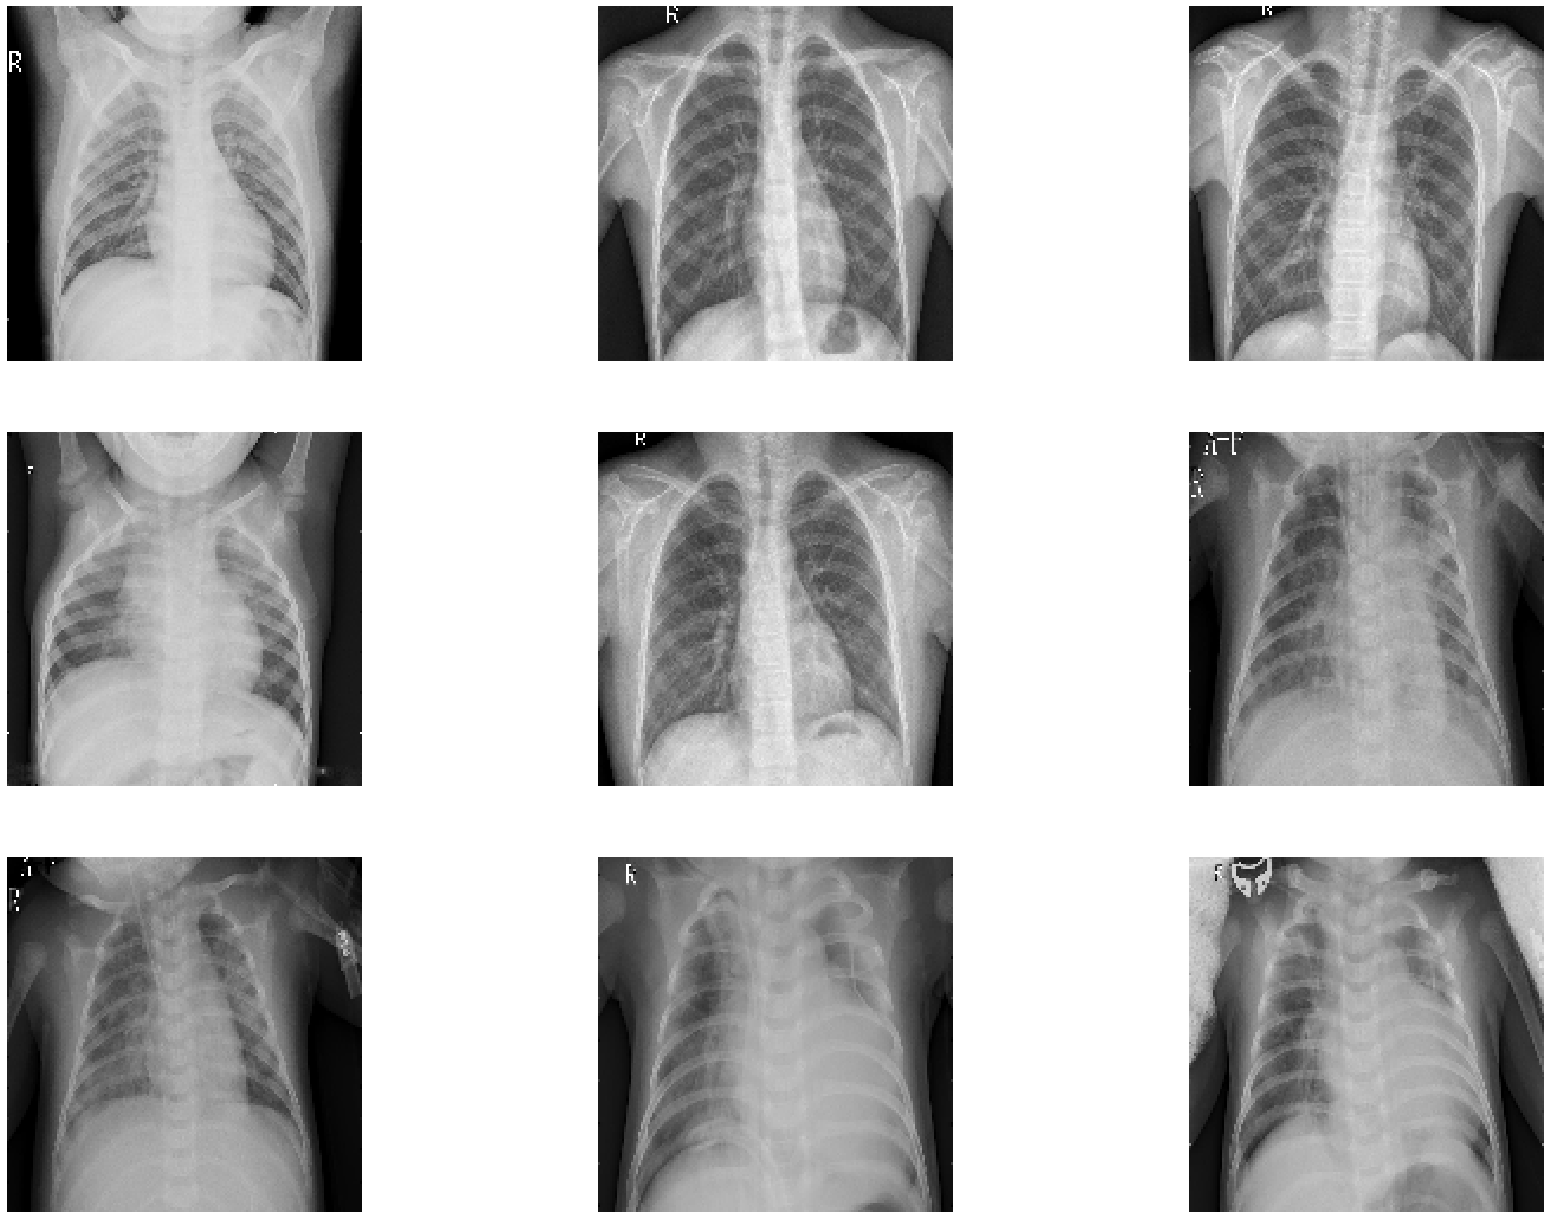

In [209]:
image = ['normal_1.jpeg','normal_2.jpeg','normal_3.jpeg','normal_4.jpeg','normal_5.jpeg',
         'pneumonia_1.jpeg','pneumonia_2.jpeg','pneumonia_3.jpeg','pneumonia_4.jpeg']

visualize_images(image)

From the images above, it is very difficult for normal people to tell whether people suffer from pneumonia or not just by looking at the x-ray images. As we can see, there is hardly any distinguishable feature that we can spot to conclude whether people suffer from pneumonia or not unless you are professional and expert doctors.

This is where I think a computer can do much better than normal people. For normal people, the accuracy of choosing whether people have pneumonia based on images above is around 50%, i.e we just random guessing. However, computer can predict this phenomenon with a much greater accuracy by extracting some of the features of images in a way that normal person's vision couldn't spot. Let's see if this assumption is true by modeling a CNN model.

The default CNN model that will be built in this project consists of five convolutions layer, each with relu activation functions followed by max pooling layer. Then it will be flattened and fully connected to a dense layer before outputting the final single dense layer with one neuron.


Let's define a function to build the model.

## Build Default CNN Model

In [14]:
def get_default_model():
    
    model = Sequential([
    
    # First convolution
        Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
    
    # Second convolution
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Third convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Fourth convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Fifth convolution
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
    
    # Flatten the results
        Flatten(),
    
    # Dense hidden layer
        Dense(512, activation='relu'),
        Dropout(0.2),
    
    # Output neuron. 
        Dense(1, activation='sigmoid')
    ])
    
    return model

Next, we can summarise the model that we have just built and see how many parameters are there that will be generated considering the default model.

In [15]:
model = get_default_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 64)       

Now we can compile the CNN model that we have just built. As the optimizer, Adam optimizer will be applied and because we only have two categories, whether a person is healthy or having a pneumonia, then we should use binary cross entropy as the loss function. For the metrics, accuracy will be applied in this project.

In [16]:
#optimizer = Adam(lr = 0.001)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
train_dir = os.path.join('D:/Learning/Data_Science_Mini_Project/Pneumonia_Detection_Using_Transfer_Learning/chest_xray/train/')
test_dir = os.path.join('D:/Learning/Data_Science_Mini_Project/Pneumonia_Detection_Using_Transfer_Learning/chest_xray/test/')
#train_generator, validation_generator = image_gen(train_dir, val_dir)

Next, we need to build the image generator. The application of image generator is necessary since in the original dataset, there is no label that is readily available for the images. With image generator, all we need to do is to define a path to the directory where the training set and test set resides. Then, image generator will automatically label the training dataset into two categories, whether the image is classified as normal or pneumonia based on the directory of the images.

With image generator, we can also artificially increase the number of the training set by applying several image augmentations on the fly. In this project, the image augmentations that will be applied are image rotation, image zoom, shifting the width and height of the image, and normalizing the image. Then, 0.1 portion of the training set will be splitted into validation set to measure the model performance before we use the model to predict test images.

Let's define a function to do the things above.

## Building Image Data Generator

In [21]:
def image_gen_w_aug(train_parent_directory, test_parent_directory):
    
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      featurewise_center=False, 
                                      samplewise_center=False, 
                                      featurewise_std_normalization=False,  
                                      samplewise_std_normalization=False, 
                                      zca_whitening=False, 
                                      rotation_range = 30,  
                                      zoom_range = 0.2, 
                                      width_shift_range=0.1,  
                                      height_shift_range=0.1,
                                      validation_split = 0.1)
    
  
    
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                       target_size = (150,150),
                                                       batch_size = 512,
                                                       class_mode = 'binary',
                                                       subset='training')
    
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                                          target_size = (150,150),
                                                          batch_size = 52,
                                                          class_mode = 'binary',
                                                          subset = 'validation')
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                                     target_size=(150,150),
                                                     batch_size = 62,
                                                     class_mode = 'binary')
    
    return train_generator, val_generator, test_generator

## Training the Default Model

Next, after we compile the model and build the image data generator, we can start to train the model. Before that, let's call the image generator function above and see how many images are there in training-validation-test sets.

In [22]:
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, test_dir)

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


As we can see above, we have 4695 images in training sets which contain 2 classes: normal and pneumonia. Meanwhile, we have 521 images in the validation sets and 624 images for the test sets.

Next, we can start to train the model. The model will be trained in 15 epochs and let's see the loss and accuracy of the model in the training set and validation set soon.

In [23]:
history_aug = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator)

Epoch 1/15
10/10 [==============================] - 128s 13s/step - loss: 0.6214 - accuracy: 0.7127 - val_loss: 0.5950 - val_accuracy: 0.7428
Epoch 2/15
10/10 [==============================] - 107s 11s/step - loss: 0.5829 - accuracy: 0.7429 - val_loss: 0.5765 - val_accuracy: 0.7428
Epoch 3/15
10/10 [==============================] - 125s 13s/step - loss: 0.5753 - accuracy: 0.7429 - val_loss: 0.5718 - val_accuracy: 0.7428
Epoch 4/15
10/10 [==============================] - 124s 12s/step - loss: 0.5668 - accuracy: 0.7429 - val_loss: 0.5557 - val_accuracy: 0.7428
Epoch 5/15
10/10 [==============================] - 101s 10s/step - loss: 0.5247 - accuracy: 0.7436 - val_loss: 0.5053 - val_accuracy: 0.7447
Epoch 6/15
10/10 [==============================] - 109s 11s/step - loss: 0.4747 - accuracy: 0.7640 - val_loss: 0.5226 - val_accuracy: 0.7582
Epoch 7/15
10/10 [==============================] - 106s 11s/step - loss: 0.4676 - accuracy: 0.7798 - val_loss: 0.4677 - val_accuracy: 0.8407
Epoch 

As we can see above, at 15 epochs, the accuracy in the training set is around 89.2%, while in the validation set the accuracy is around 87.3%. However, let's define a plot function to see the loss and accuracy of the model after every epochs.

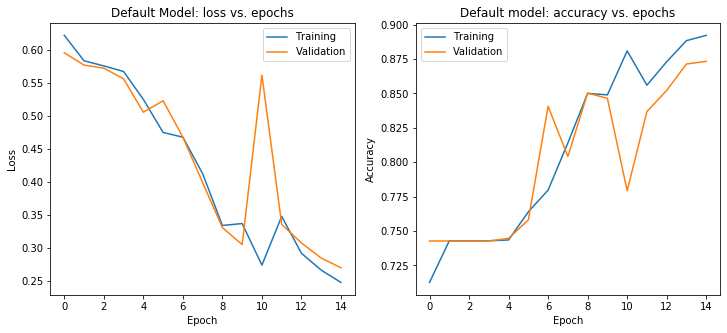

In [42]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Default Model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.title('Default model: accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

From the plot generated above, we can see that the there is not much difference between the accuracy from training set and the validation set, which means that the model doesn't really have an overfitting problem. However, we can see that the training accuracy after 15 epochs is just below 90% and obviously I think we can improve this accuracy score by applying different architecture.

Before we do that, let's evaluate the model with the images from the test set.

In [25]:
filenames = test_generator.filenames

num_of_samples = len(filenames)

In [30]:
accuracy_test = model.evaluate(test_generator, steps = np.ceil(num_of_samples/62))

11/11 [==============================] - 7s 631ms/step - loss: 0.2939 - accuracy: 0.8878


As we can see, the default model achieved 88.78% accuracy in the test set. This is obviously not bad at all but definitely we can improve this. Let's see if the accuracy of the model can be improved with the application of the famous pre-trained model, which is Inception model.

## Transfer Learning Using InceptionV3 Model

Next, let's implement a pre-trained model to see whether the metrics for the problem in this project is improved or not. The pre-trained model that will be implemented is InceptionV3 model. This is a very big and deep model implemented by Szegedy et al. for Computer Vision problem back in 2015. The reference regarding the detailed architecture can be seen from the original paper via this link https://arxiv.org/abs/1512.00567.

Since this is a very deep model, of course the training time of data will be unbearable on a CPU. Hence, in order to reduce the computation cost, I will only implement InceptionV3 model until a layer called 'mixed5'. Also, the weights will be imported from when this model was trained for ImageNet, which contains hundreds of thousand of images. Then, the weights that are already obtained in each layer will be freezed.

Let's load the pre trained model first.

In [43]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')

In [44]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

As we can see from the model summary above, this Inception model is humongous and very deep, in which there are over 21 million parameters involved. As mentioned earlier, not all parts of the model will be used. For this project, the model architecture that will be used will be only until 'mixed5' layers.

Then, the weights in all layers will be freezed such that the weights that are trainable are the weights in additional dense layers after the last output of 'mixed5' layer is flattened. Let's do all these things.

In [45]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed5')
last_output = last_layer.output

In [46]:
def model_output_for_TL (pre_trained_model, last_output):

    x = Flatten()(last_output)
    
    # Dense hidden layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output neuron. 
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(pre_trained_model.input, x)
    
    return model

From the code above, the additional dense layers on top of the flattened version of the last output of Inception model has been built. Next, let's generate the image data generator and compile the model using the same setup as the default model implemented earlier. 

In [50]:
model_TL = model_output_for_TL(pre_trained_model, last_output)

In [51]:
model_TL.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Next, we can start to train the model using 15 epochs.

In [52]:
history_TL = model_TL.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator)

Epoch 1/15
10/10 [==============================] - 126s 13s/step - loss: 3.3173 - accuracy: 0.5851 - val_loss: 0.4463 - val_accuracy: 0.7428
Epoch 2/15
10/10 [==============================] - 136s 14s/step - loss: 0.5944 - accuracy: 0.7442 - val_loss: 0.3611 - val_accuracy: 0.7447
Epoch 3/15
10/10 [==============================] - 124s 12s/step - loss: 0.3680 - accuracy: 0.7538 - val_loss: 0.3549 - val_accuracy: 0.7678
Epoch 4/15
10/10 [==============================] - 126s 13s/step - loss: 0.3220 - accuracy: 0.8175 - val_loss: 0.2823 - val_accuracy: 0.8733
Epoch 5/15
10/10 [==============================] - 124s 12s/step - loss: 0.2561 - accuracy: 0.8884 - val_loss: 0.2256 - val_accuracy: 0.9175
Epoch 6/15
10/10 [==============================] - 122s 12s/step - loss: 0.2047 - accuracy: 0.9174 - val_loss: 0.1782 - val_accuracy: 0.9271
Epoch 7/15
10/10 [==============================] - 123s 12s/step - loss: 0.1873 - accuracy: 0.9206 - val_loss: 0.1611 - val_accuracy: 0.9386
Epoch 

As we can see from the history above, at epochs 15, the training accuracy is 95,5%, which is a massive improvements from the default model, which achieved only 89% accuracy with 15 epochs. On the validation set, the accuracy is more or less the same with training set, which is 95.5%. It is also a massive improvements from the default model, which achieved 87.3% in the validation set. 

With the accuracy result in the training set that is not that different with the validation set, we can say that the model generalized well with unseen data. Let's plot the accuracy and loss of training and validation set in each epochs.

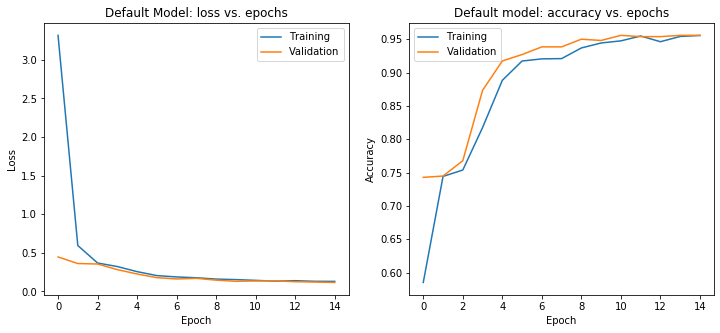

In [64]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(history_TL.history['loss'])
plt.plot(history_TL.history['val_loss'])
plt.title('Default Model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(history_TL.history['accuracy'])
plt.plot(history_TL.history['val_accuracy'])
plt.title('Default model: accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.show()

Next, let's evaluate the model using the test set.

In [53]:
accuracy_test = model_TL.evaluate(test_generator, steps = np.ceil(num_of_samples/62))

11/11 [==============================] - 9s 813ms/step - loss: 0.2919 - accuracy: 0.9119


From the result above, we can see that the model with transfer learning yields to an accuracy of 91.2%. This is an improvement compared to the accuracy with the default model, which achieved only 88.8% in the test set. Next, let's do the fun part, which is predicting the test images using both models that have been applied in this project.

## Predicting Test Images Using Both Models

Now let's see how each of the model applied in this project performs to predict some images in the test set. Before we do that, first let's define a function to import the test images, resize them to the desired pixels, and then output the prediction result.

In [190]:
import cv2

def import_and_predict(image_data, model):
    
    predictions = []
    values = []
    
    for i in range (len(image_data)):
        
        sigmoid = "None"
        pred = "None"
        
        img = mpimg.imread(image_data[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resize = (cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_CUBIC))/255.
    
        img_reshape = img_resize[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
      
        if prediction[0][0] > 0.5:
            
            sigmoid = "Sigmoid: "+ str(round(prediction[0][0],3))
            pred = "Prediction: Pneumonia"
            
        else:
            sigmoid = "Sigmoid: "+ str(round(prediction[0][0],3))
            pred = "Prediction: Normal"
        
        values.append(sigmoid)
        predictions.append(pred)
        
    return values, predictions

Next we can call the function defined above to import the test images and run the prediction on each of test images.

In [191]:

image_test = ['normal_1.jpeg','normal_2.jpeg','normal_3.jpeg','normal_4.jpeg','normal_5.jpeg','normal_6.jpeg',
             'normal_7.jpeg','normal_8.jpeg','normal_9.jpeg','pneumonia_1.jpeg','pneumonia_2.jpeg',
              'pneumonia_3.jpeg','pneumonia_4.jpeg','pneumonia_5.jpeg','pneumonia_6.jpeg']

c_def_model, p_def_model = import_and_predict(image_test, model)

Next, we need to define a function to visualize the images as well as the label of the images (whether the images belong to healthy person or person with pneumonia). Also, each images will be annotated with its corresponding prediction as well as the value of the sigmoid function to make it easier to check whether the prediction corresponds to the image labels or not.

In [218]:
def visualize_xRay(image_test, confidence, prediction):
    
    n_row = 5
    n_cols = 3
    color_pixel = 150
    
    plt.figure(figsize=(40,40))
    
    for i in range (len(image_test)):
        
        img = mpimg.imread(image_test[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resize = (cv2.resize(img, dsize=(color_pixel, color_pixel), interpolation=cv2.INTER_CUBIC))/255.
    
        plt.subplot(n_row,n_cols,i+1)
        plt.title(image_test[i],fontsize=30, color='r')
        plt.imshow(img_resize)
        plt.axis('off')
        
        plt.annotate(prediction[i],((color_pixel/2)-40,color_pixel-20),fontsize=20, color='r')
        plt.annotate(confidence[i],((color_pixel/2)-40,color_pixel-10), fontsize=20, color='r')
        
    #plt.savefig('pneumonia_predict.jpeg', format='jpeg')

### Prediction with Default Models

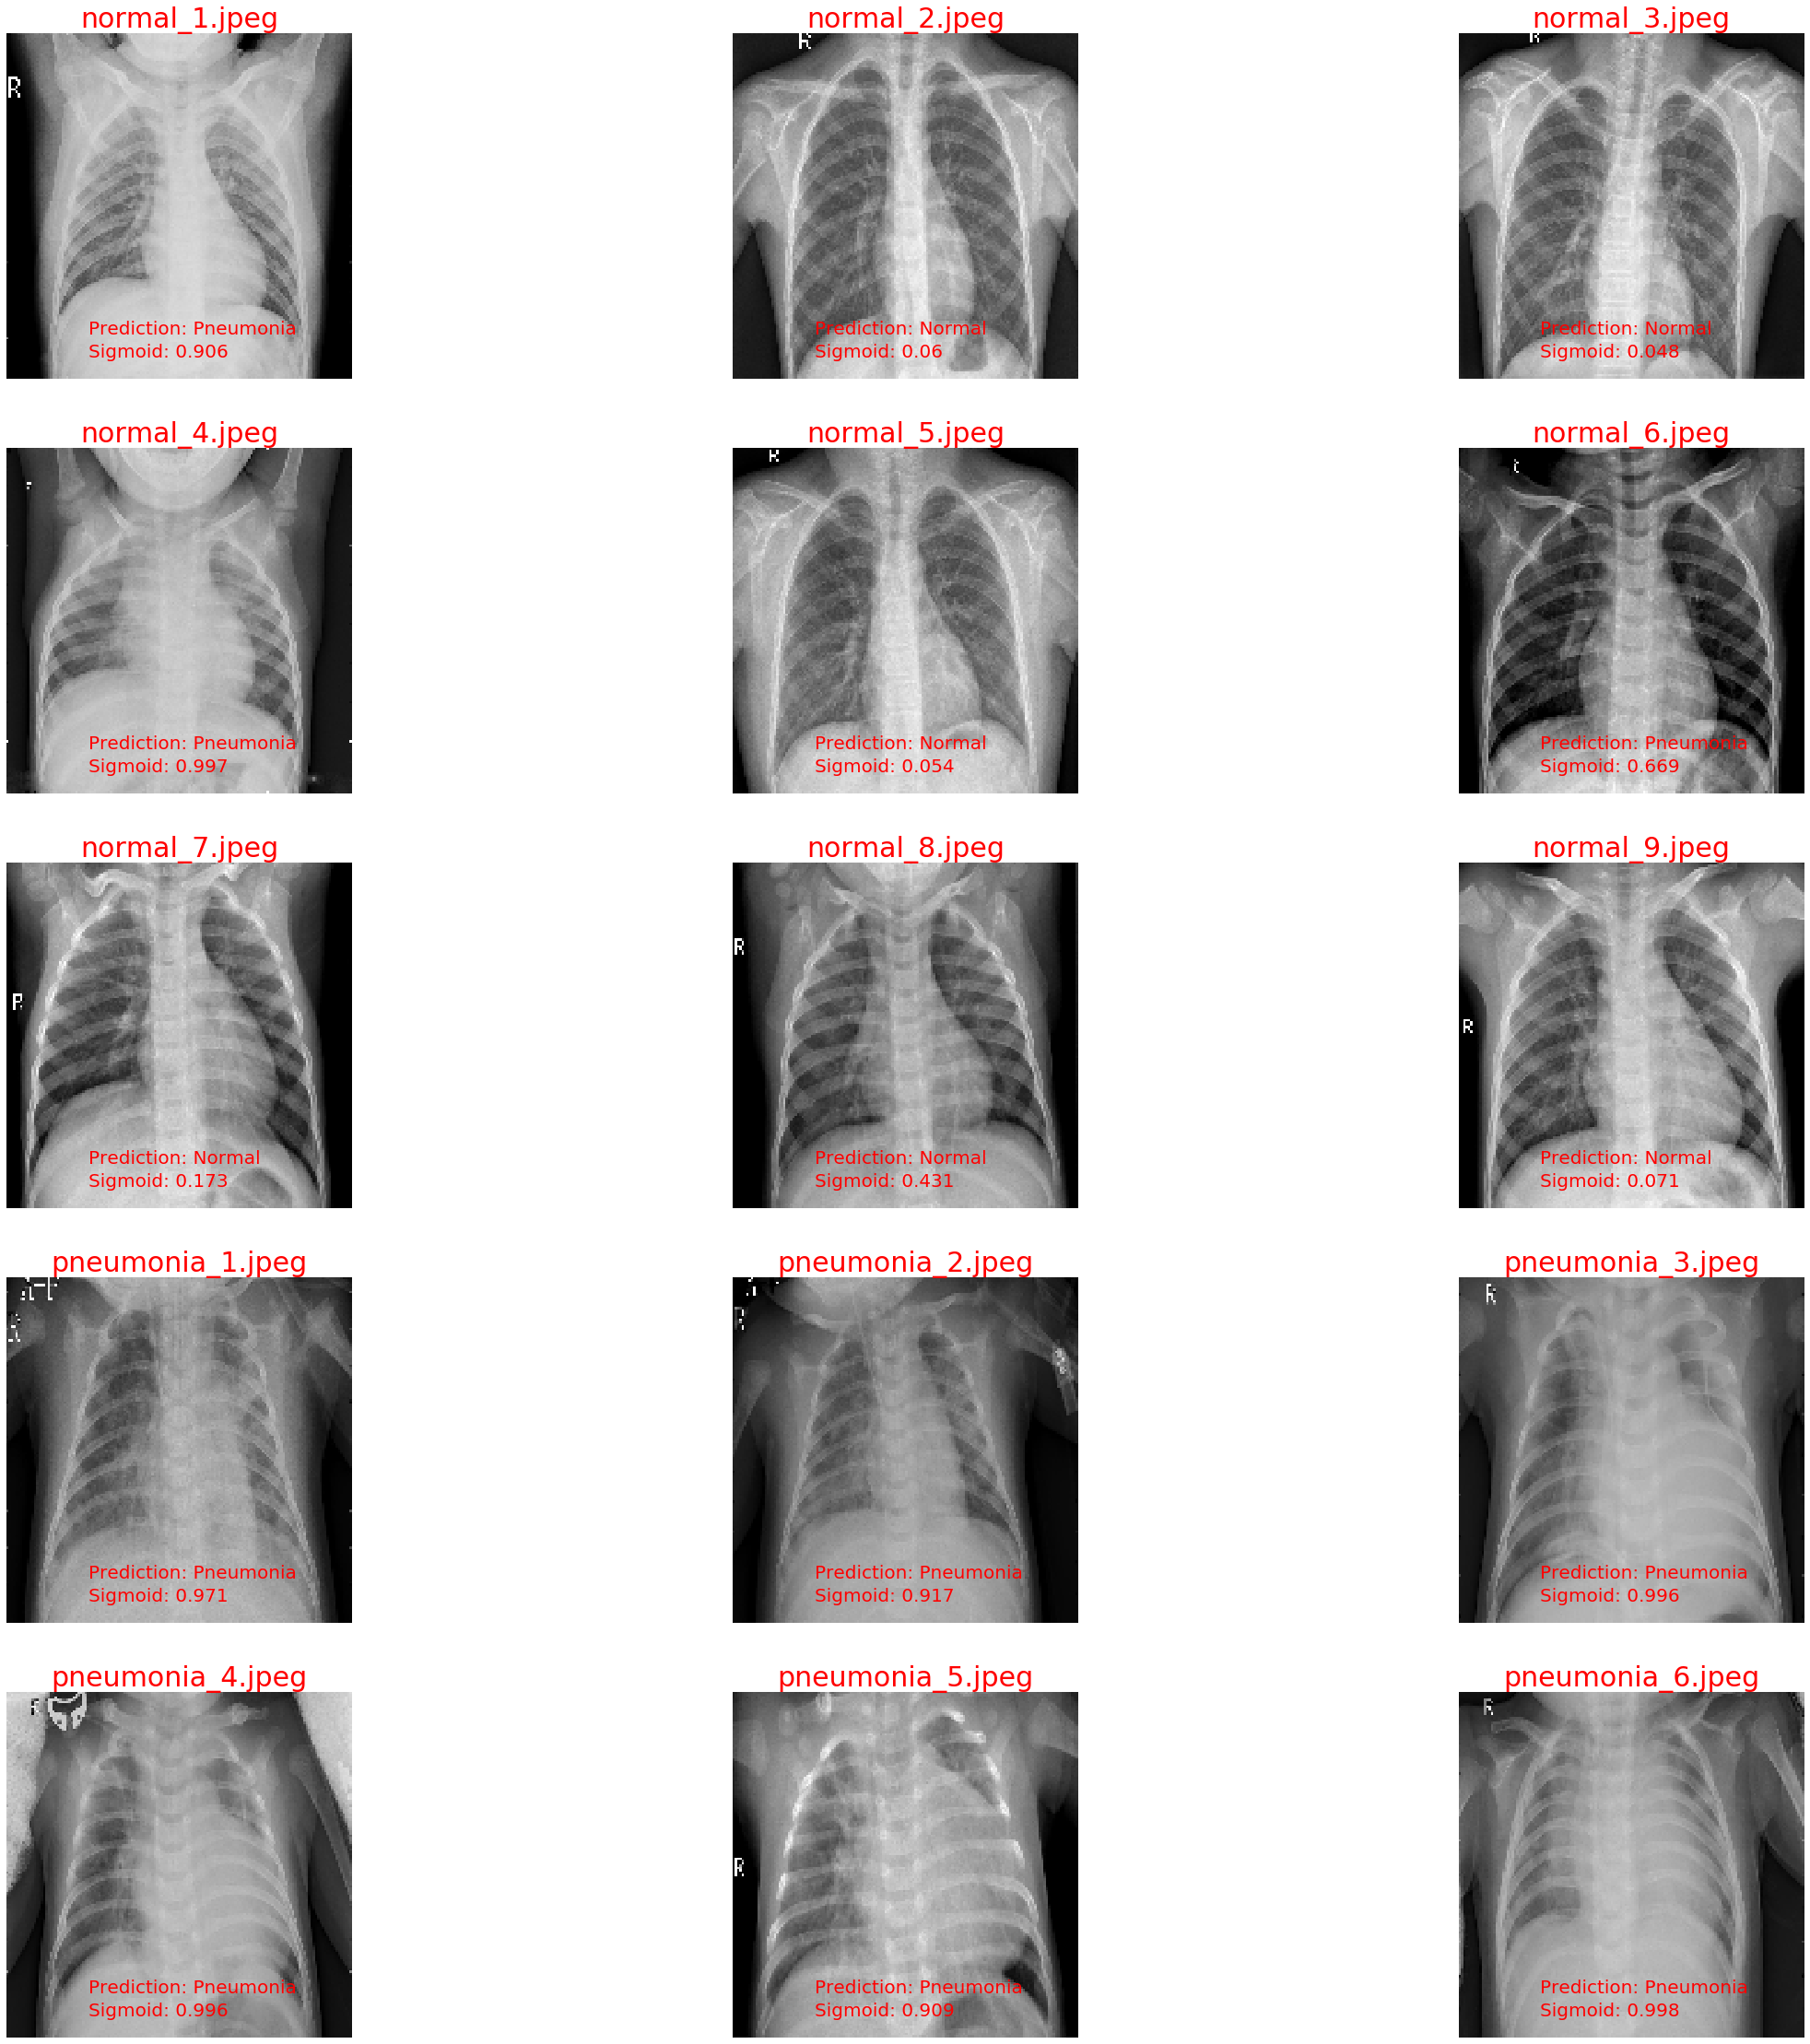

In [202]:
visualize_xRay(image_test, c_def_model, p_def_model)

From the prediction result above, we can see that out of 15 test images, the model predicts 12 images correctly. If we take a closer look, all of the images that have been misclassified by the model are the images where people are healthy. This means that we have Type I error here, that the model predicts that a person has a pneumonia when he or she is actually fine.

One of the biggest reason on why we have Type I error is due to the fact that in the training set, we have only 1341 training images of healthy people compared to 3875 training images of people with pneumonia.

Let's see if the model with transfer learning from Inception architecture can actually improves the prediction.  

### Prediction Using Transfer Learning Model

In [211]:
c_TL_model, p_TL_model = import_and_predict(image_test, model_TL)

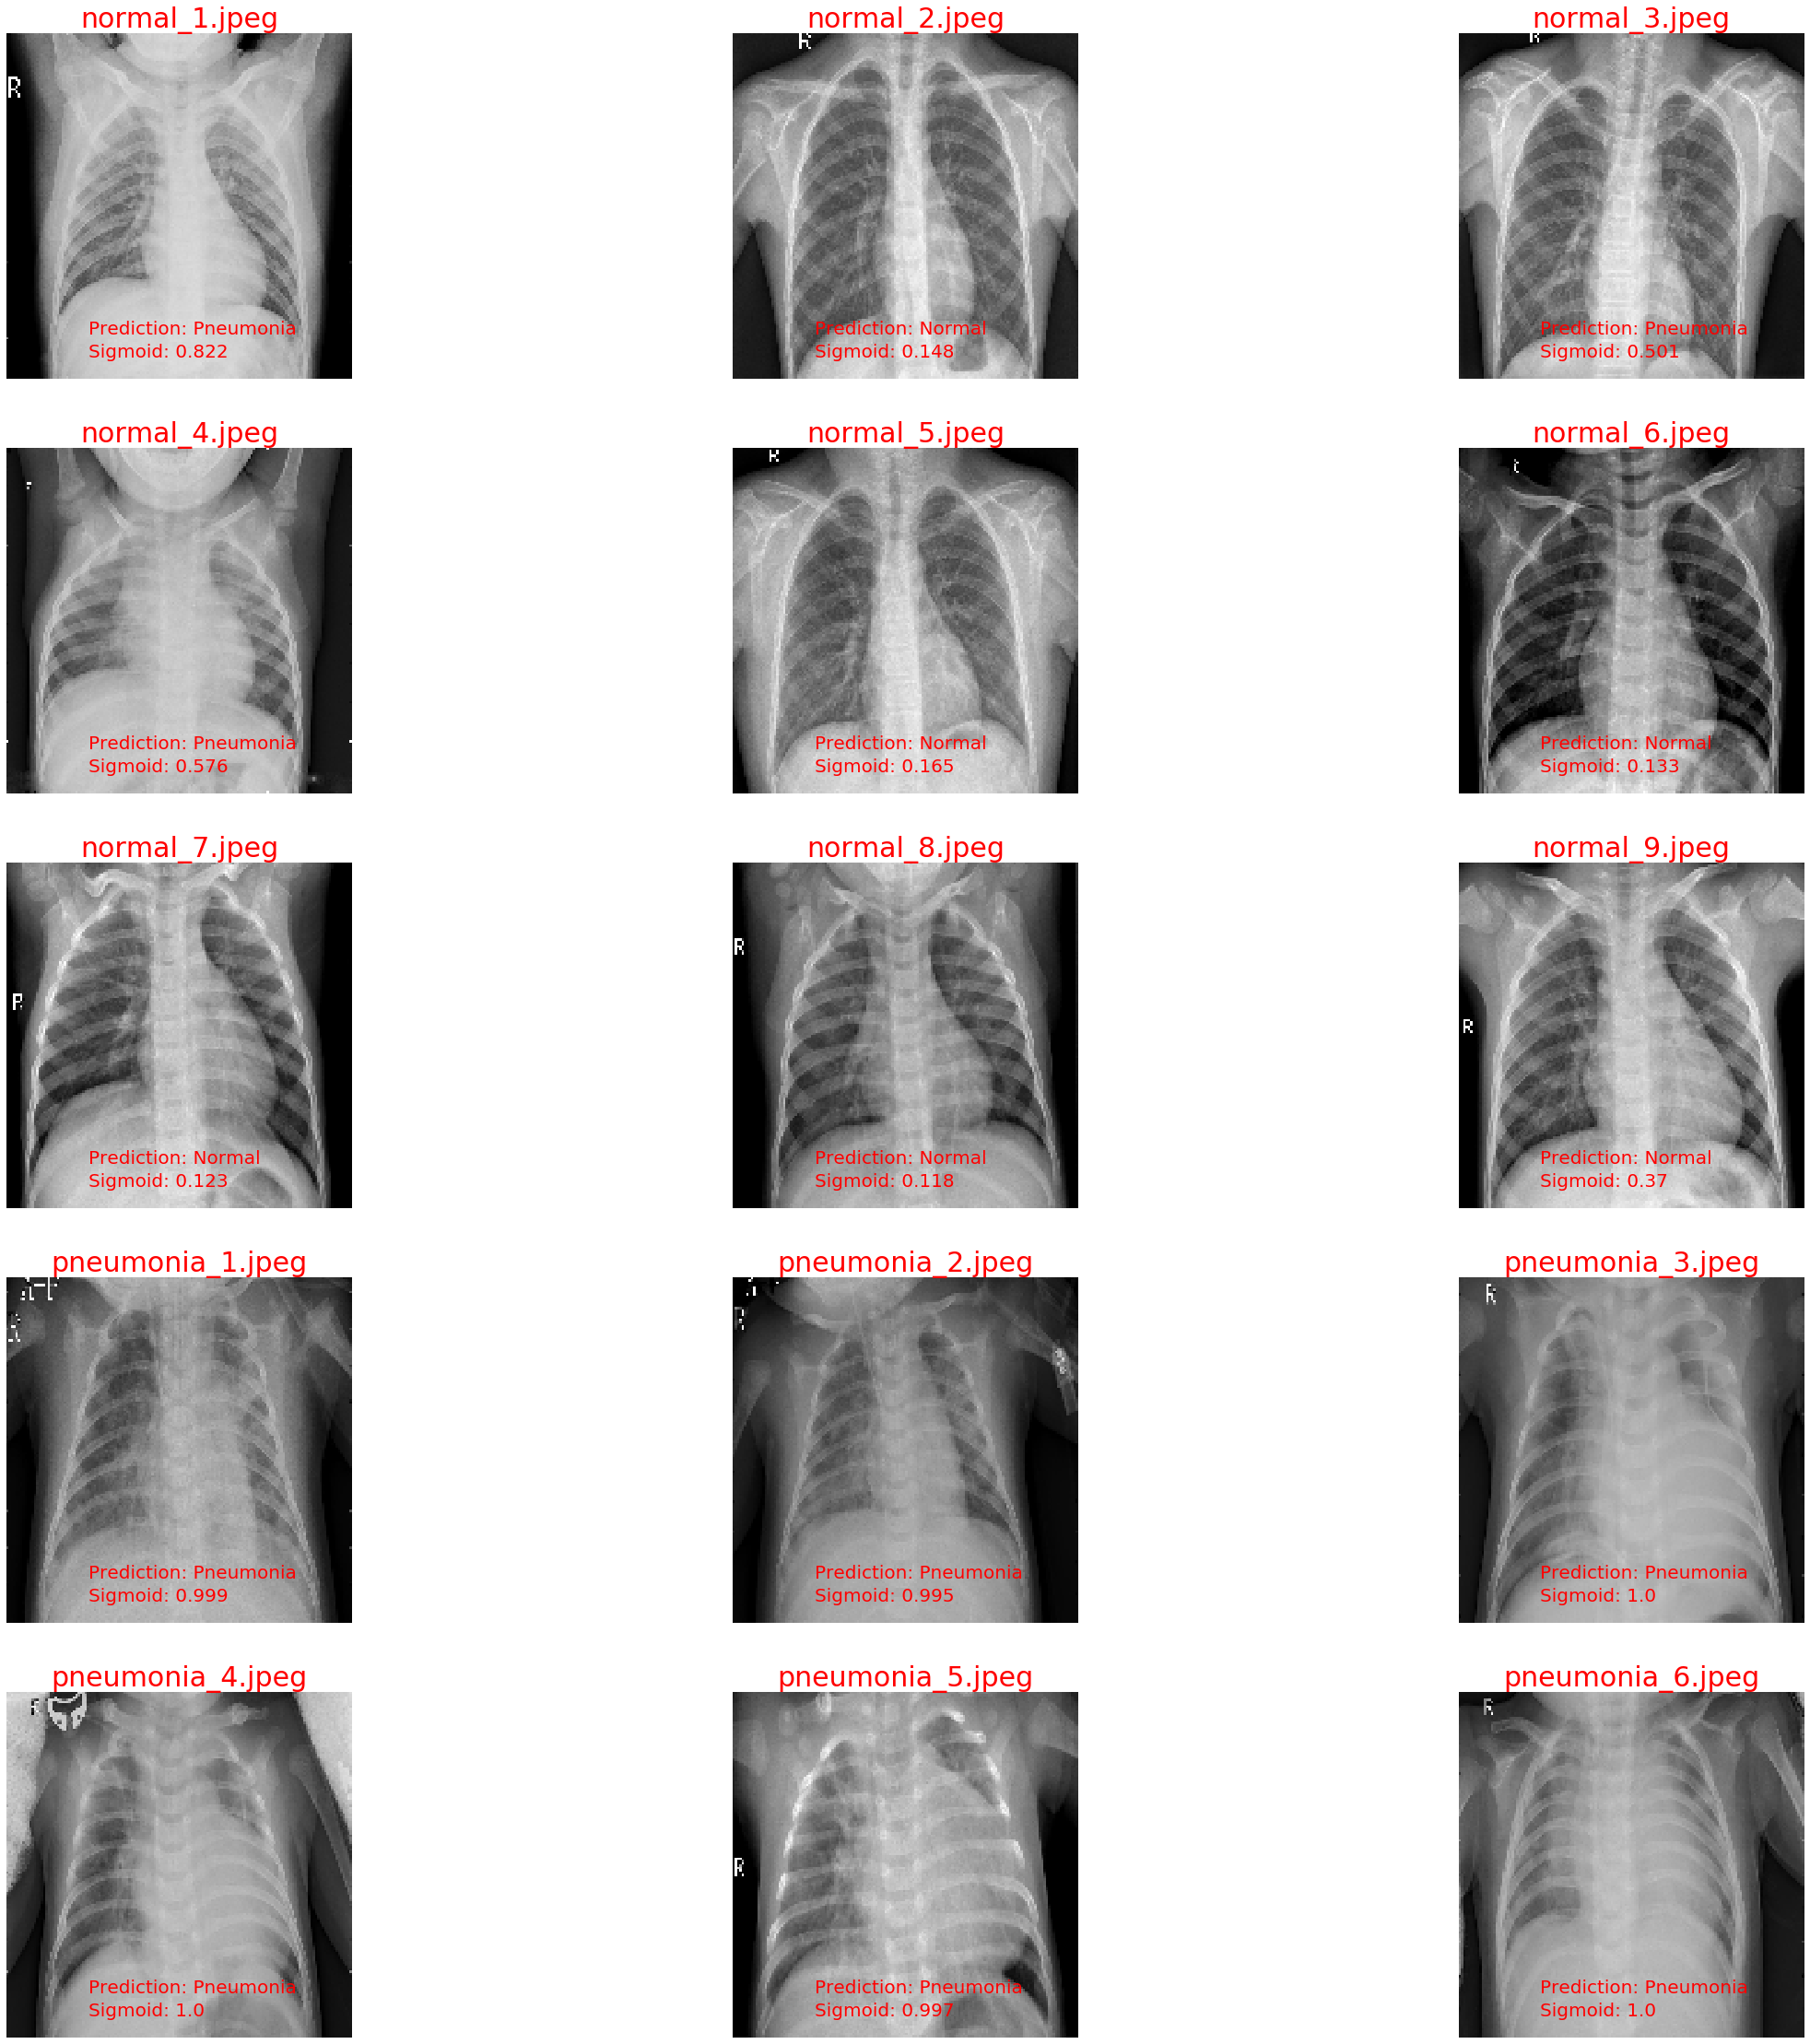

In [219]:
visualize_xRay(image_test, c_TL_model, p_TL_model)

From the prediction above, it turns out that the model with transfer learning also achieved similar result with the default model, in which this model predicts 12 out of 15 test images correctly. One notable difference and also improvement from this model compared to the default model is the confidence in the sigmoid function value.

As we can see from images above, when the X-ray image is indicating that people have pneumonia, the model with transfer learning predicts that people indeed have pneumonia with higher confidence than the default model, i.e the sigmoid value is always close or even equals to 1. For the X-ray images of healthy people, both models perform similarly, in which one model is better at predicting one image than the other. 

In order to improve the prediction power of the model, one obvious thing that should be implemented is by increasing the training X-ray images of healthy people such that we have equal proportion between X-ray images of healthy people and people with pneumonia.